In [1]:
!pip install perceval-quandela

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.3/884.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 1.6 MB/s eta 0:00:00


In [2]:
import perceval as pcvl
import perceval.components as comp

from perceval.components import PS, BS, PERM, Port
import numpy as np

from perceval.rendering.circuit import DisplayConfig, SymbSkin, PhysSkin
from perceval.utils import Encoding

# Single Photon Path Entanglement

In this project, we refer to the entanglement between spatial modes of a photon as single photon path entanglement. When the polarized photon passes through the first beam splitter, the Fock spaces for the two output modes are entangled. This effect is due to the photon being delocalized over multiple spatial locations simultaneously, analogous to the quantum mechanical definition of superposition.

Our goal through the course of this paper will be to manipulate the spatial mode system such that the polarization state mirrors the third Bell state:

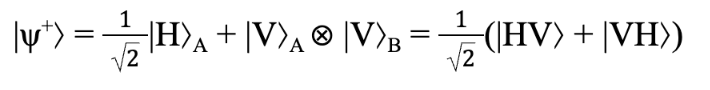


The first step is to split the incoming photon into two modes using a beamsplitter in order to define the SPTQ system. However, we must be careful in using this operation, as the BS affects the behavior of waveplates and phase-shifters used to rotate the polarization of the spatial modes. For example, consider the effects on a toy model using a Pauli X-gate, which is represented as a half waveplate (λ/2) rotated π/4 radians about the optical axis.


In [9]:
delta1 = pcvl.Parameter("delta1")
xsi1 = pcvl.Parameter("xsi1")

delta2 = pcvl.Parameter("delta2")
xsi2 = pcvl.Parameter("xsi2")

delta3 = pcvl.Parameter("delta3")
xsi3 = pcvl.Parameter("xsi3")

phi1 = pcvl.Parameter("phi1")

In [11]:
delta1.set_value(np.pi/2)
xsi1.set_value(np.pi/8)

delta2.set_value(np.pi/2)
xsi2.set_value(np.pi/4)

delta3.set_value(np.pi/2)
xsi3.set_value(0)

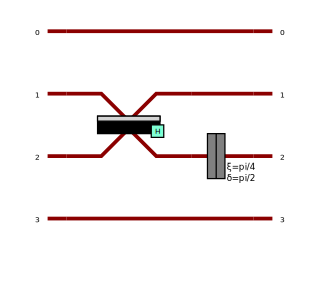

In [14]:
circ = (pcvl.Circuit(4)
       .add(1, comp.BS.H())
       .add(2, comp.WP(delta=delta2, xsi=xsi2)))
pcvl.pdisplay(circ)

In [15]:
processor = pcvl.Processor("SLOS", circ)
processor.add_port(0, Port(Encoding.DUAL_RAIL, 'port1'))
processor.add_port(2, Port(Encoding.DUAL_RAIL, 'port2'))

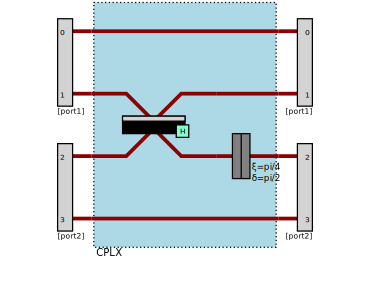

In [16]:
pcvl.pdisplay(processor, recursive=True)

In [17]:
input_state = pcvl.BasicState("|0,1,0,0>")
processor.with_input(input_state)
sampler = pcvl.algorithm.Sampler(processor)
sample_count = sampler.sample_count(10000)

In [18]:
print(sample_count['results'])

{
  |0,0,1,0>: 5070
  |0,1,0,0>: 4930
}


In [50]:
results_dict = dict(sample_count['results'])
possible_keys = ["|1,0,0,0>", "|0,1,0,0>", "|0,0,1,0>", "|0,0,0,1>"]
padded_results_dict = {}
stringified_results_dict = {str(k): v for k, v in results_dict.items()}
padded_results_dict = {k: int(stringified_results_dict.get(k, 0)) for k in possible_keys}

print(padded_results_dict)


{'|1,0,0,0>': 0, '|0,1,0,0>': 4930, '|0,0,1,0>': 5070, '|0,0,0,1>': 0}


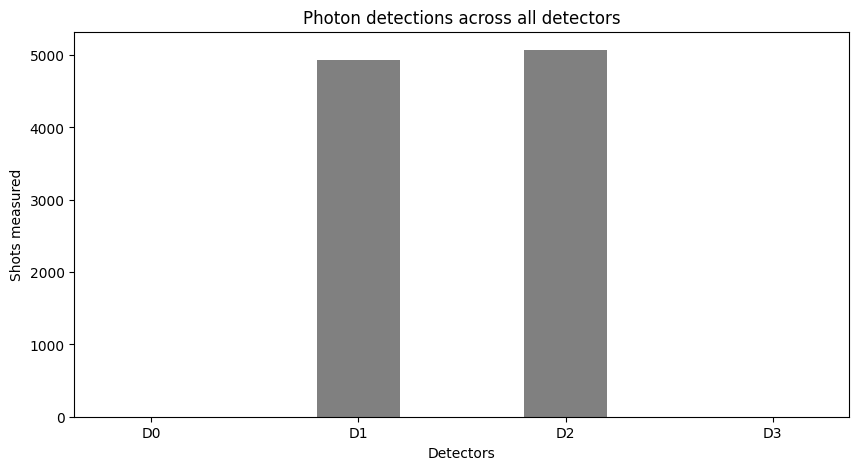

In [52]:
import matplotlib.pyplot as plt

detectors = ["D0", "D1", "D2", "D3"]
values = list(padded_results_dict.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(detectors, values, color ='gray',
        width = 0.4)

plt.xlabel("Detectors")
plt.ylabel("Shots measured")
plt.title("Photon detections across all detectors")
plt.show()

**Key Finding:** In this model, a half waveplate rotated π/4 radians cannot be linearly mapped to a Pauli X gate, but rather the combination of a Pauli X gate followed by a Hadamard gate.


Combining these operators into a single matrix, we can see that a bit-flip in our single photon, 2-qubit model can be represented as follows:
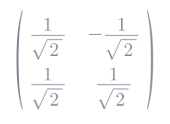

At a default value of theta = π/2, the beamsplitter behaves as a Hadamard gate in the spatial basis, effectively mixing the two paths such that the photon has a 50-50 probability in each state. However, as mentioned earlier, our experiment is focused on the polarization state evolution, rather than the spatial. From this standpoint, the initial beam splitter operation can be represented as a black box that introduces phase interferences and amplitude biases to the polarization states of the system. These interferences are complex and not directly measurable in the Perceval framework but are known to skew measurement distributions in entanglement circuits.

While this skew isn't easily visible in our toy model, its effects will be clear when constructing entanglement.


# Bell State Entanglement


To define this circuit in Perceval, we must initialize the polarization states of both spatial mode qubits. Initially, we defined that the bit flip operation corresponds to a half waveplate rotated π/4 radians followed by a Hadamard gate. Drawing from past literature, the Hadamard operation corresponds to a half waveplate rotated π/8 radians.

Following our encoding, we will entangle the polarization states using the standard optical BSM procedure [5]. Kim et al. defines this procedure as two photons meeting and interfering at a BS. The paths are then passed through two polarizing beam splitters. We can extend this procedure to describe the overlap between two spatial modes.

This means that we must align the beams in such a way that they recombine at a second BS at the same time. To accomplish this, we set up a Mach-Zehnder interferometer scheme following our initial encoding.


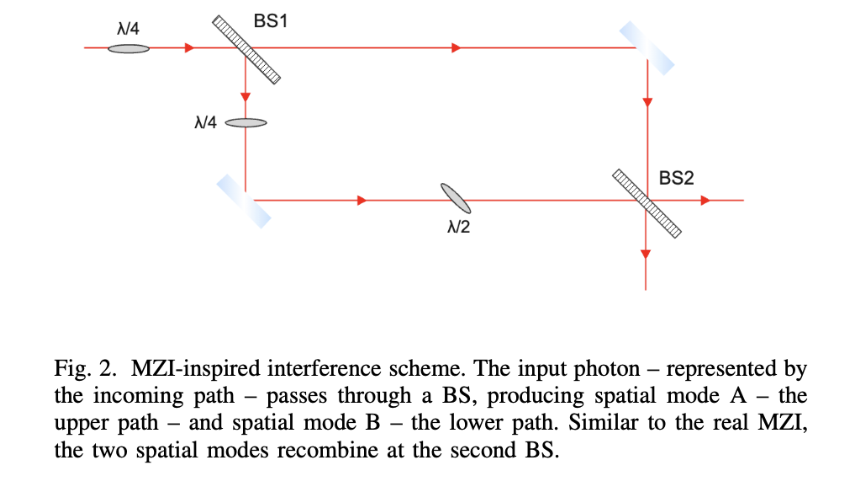

Experimentally, some action must occur to construct the entangled state. The standard BSM procedure introduces two polarizing beam splitters (PBS) and involves a technique known as Hong-Ou-Mandel interference.

Traditionally, this effect occurs when two indistinguishable photons perfectly overlap at the PBS, causing them to exit from the same port 100% of the time. We consider extending this concept to two spatial modes as a verification of indistinguishability. Our research defines that each photon coincidence at the detector will correspond to perfectly overlapped spatial modes, indicating HOM interference. In an unbiased model, perfect indistinguishability required for entanglement corresponds to a roughly even distribution of photon coincidences. In other words, the modes are indistinguishable at every detector.

Therefore, our controlled-NOT gate in Perceval can be constructed as follows:


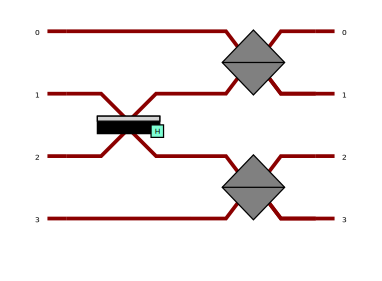

In [54]:
circ = (pcvl.Circuit(4)
       .add(1, comp.BS().H())

       .add(0, comp.PBS())
       .add(2, comp.PBS()))
pcvl.pdisplay(circ)

We now have all of the optical components to add to our interferometer in Perceval. The result is shown below.

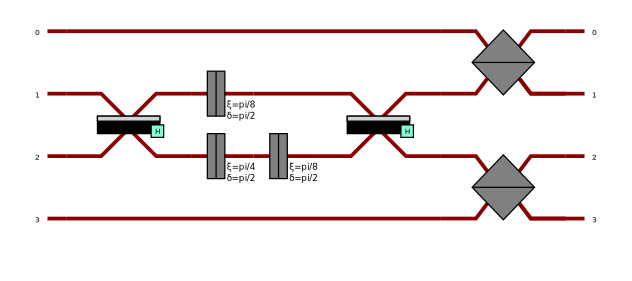

In [56]:
mzi = (pcvl.Circuit(4)
       .add(1, comp.BS().H())

       .add(1, comp.WP(delta=delta1, xsi=xsi1)) # h gate
       .add(2, comp.WP(delta=delta2, xsi=xsi2)) # x gate followed by h gate
       .add(2, comp.WP(delta=delta1, xsi=xsi1)) # h gate

       .add(1, comp.BS().H())

       .add(0, comp.PBS())
       .add(2, comp.PBS()))
pcvl.pdisplay(mzi)

In [62]:
processor = pcvl.Processor("SLOS", mzi)
processor.add_port(0, Port(Encoding.DUAL_RAIL, 'port1'))
processor.add_port(2, Port(Encoding.DUAL_RAIL, 'port2'))

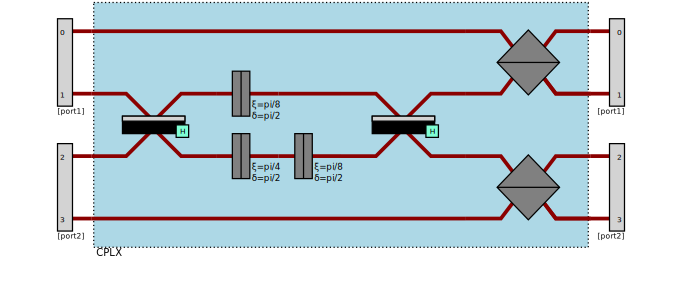

In [63]:
pcvl.pdisplay(processor, recursive=True)

In [64]:
input_state = pcvl.BasicState("|0,1,0,0>")
processor.with_input(input_state)
sampler = pcvl.algorithm.Sampler(processor)
sample_count = sampler.sample_count(10000)

In [65]:
results_dict = dict(sample_count['results'])
possible_keys = ["|1,0,0,0>", "|0,1,0,0>", "|0,0,1,0>", "|0,0,0,1>"]
padded_results_dict = {}
stringified_results_dict = {str(k): v for k, v in results_dict.items()}
padded_results_dict = {k: int(stringified_results_dict.get(k, 0)) for k in possible_keys}

print(padded_results_dict)

{'|1,0,0,0>': 2480, '|0,1,0,0>': 2495, '|0,0,1,0>': 2553, '|0,0,0,1>': 2472}


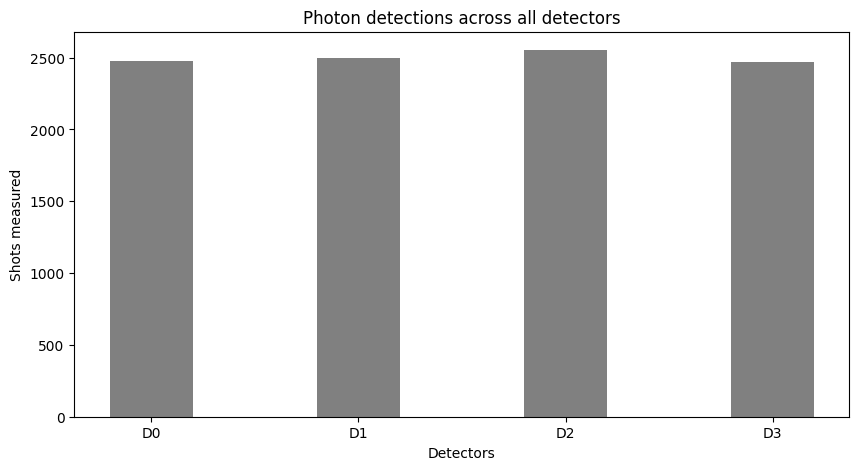

In [66]:
detectors = ["D0", "D1", "D2", "D3"]
values = list(padded_results_dict.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(detectors, values, color ='gray',
        width = 0.4)

plt.xlabel("Detectors")
plt.ylabel("Shots measured")
plt.title("Photon detections across all detectors")
plt.show()

As we can see, the circuit produces roughly uniform readings across all four detectors, indicating successful HOM interference as expected. Indistinguishable spatial mode qubits were “bunched” at each port.


To test what our circuit would look like if we did not account for the extra Hadamard contribution from the half waveplate rotated π/4 radians, we can construct the following circuit:

In [73]:
mzi = (pcvl.Circuit(4)
       .add(1, comp.BS().H())

       .add(1, comp.WP(delta=delta1, xsi=xsi1)) # h gate
       .add(2, comp.WP(delta=delta2, xsi=xsi2)) # x gate followed by h gate

       .add(1, comp.BS().H())

       .add(0, comp.PBS())
       .add(2, comp.PBS()))

In [74]:
processor = pcvl.Processor("SLOS", mzi)
processor.add_port(0, Port(Encoding.DUAL_RAIL, 'port1'))
processor.add_port(2, Port(Encoding.DUAL_RAIL, 'port2'))

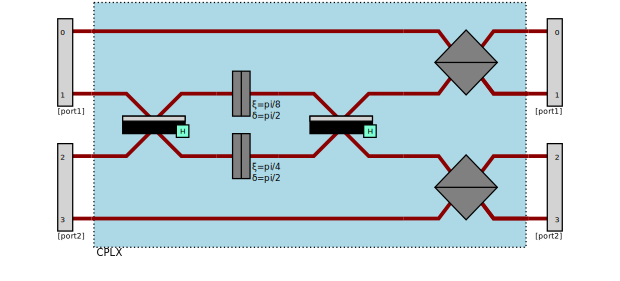

In [75]:
pcvl.pdisplay(processor, recursive=True)

In [76]:
input_state = pcvl.BasicState("|0,1,0,0>")
processor.with_input(input_state)
sampler = pcvl.algorithm.Sampler(processor)
sample_count = sampler.sample_count(10000)

In [77]:
results_dict = dict(sample_count['results'])
possible_keys = ["|1,0,0,0>", "|0,1,0,0>", "|0,0,1,0>", "|0,0,0,1>"]
padded_results_dict = {}
stringified_results_dict = {str(k): v for k, v in results_dict.items()}
padded_results_dict = {k: int(stringified_results_dict.get(k, 0)) for k in possible_keys}

print(padded_results_dict)

{'|1,0,0,0>': 1272, '|0,1,0,0>': 7264, '|0,0,1,0>': 212, '|0,0,0,1>': 1252}


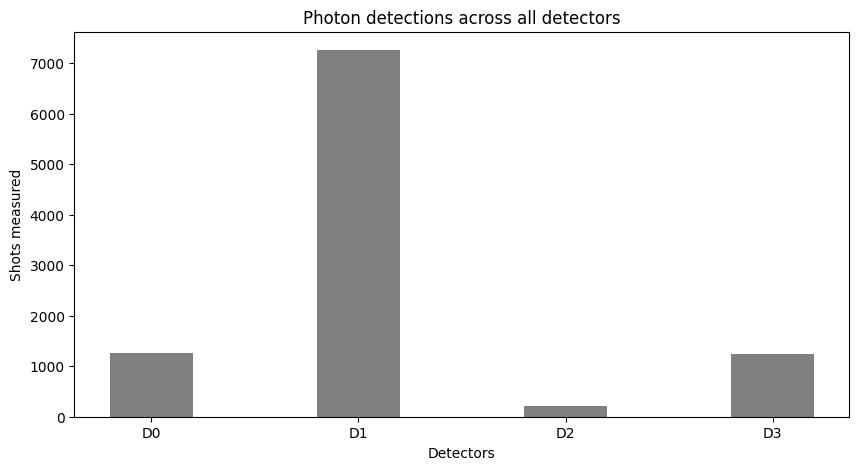

In [78]:
detectors = ["D0", "D1", "D2", "D3"]
values = list(padded_results_dict.values())

fig = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(detectors, values, color ='gray',
        width = 0.4)

plt.xlabel("Detectors")
plt.ylabel("Shots measured")
plt.title("Photon detections across all detectors")
plt.show()

At detector 1, we see a significantly higher proportion of photon detections, corresponding to indistinguishable, bunched spatial modes. However, the coincidences are much lower at the other detectors, indicating the spatial modes may not have perfectly overlapped at the second BS or at the PBS. Notice our results differ significantly from the expectation of uniformly distributed photon coincidences. This apparent skew in the distribution comes from the initial beamsplitter used to define our SPTQ system, as mentioned earlier.

A question that arises at this point is, "why is the skew from the beamsplitter not present in our initial MZI?" To answer this, we must recognize that our initial MZI -- which cancels out the extra Hadamard contribution -- produces a balanced circuit, whereas the second MZI results in an imbalanced circuit. A balanced circuit enables the effects of the black box cancel out as well, leaving us with a symmetric, unskewed distribution as initially expected.

**Important Finding:** The beamsplitter acts as a mysterious Black Box operation when the circuit is imbalanced, skewing the outcomes of measurement. The beamsplitter does not introduce polarization rotations or phase shifts when the circuit is balanced.

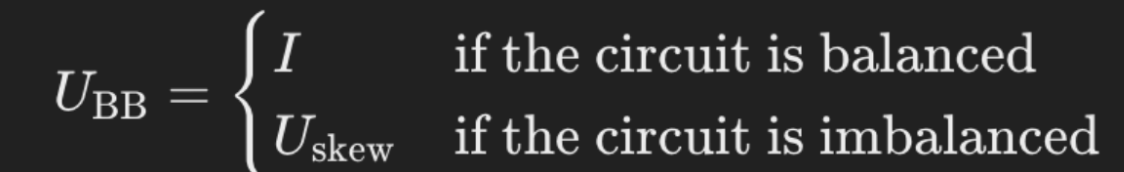

# Results

Let's consider rotating the angle of the half wave plate in eight π/4 radian increments about the optical axis and observing the changes in spatial mode indistinguishability. In other words, we are applying an RX gate. These findings can be summarized in the table below.

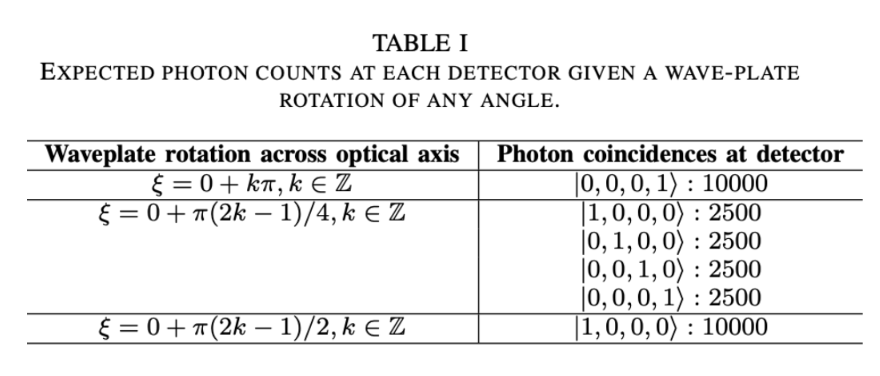

When the half-wave plate is rotated by angles in multiples of π, all photons are detected in the D3 detector, indicating unsuccessful HOM interference. When the angle is in multiples of π/4, we obtain roughly equal measurements across all four detectors, indicating successful interference. When the angle is in multiples of π/2, we see similar results to multiples of π, except all photons are now detected in the D0 detector.


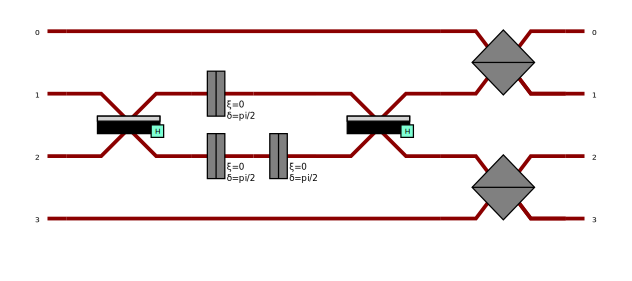

In [84]:
mzi = (pcvl.Circuit(4)
       .add(1, comp.BS().H())

       .add(1, comp.WP(delta=delta1, xsi=xsi1)) # h gate
       .add(2, comp.WP(delta=delta2, xsi=xsi2)) # x gate followed by h gate
       .add(2, comp.WP(delta=delta1, xsi=xsi1)) # h gate

       .add(1, comp.BS().H())

       .add(0, comp.PBS())
       .add(2, comp.PBS()))
pcvl.pdisplay(mzi)

In [85]:
devs = []
angles_to_test = np.linspace(0, 2*np.pi, 100)

for angle in angles_to_test:
  delta1.set_value(np.pi/2)
  xsi1.set_value(0)

  delta2.set_value(np.pi/2)
  xsi2.set_value(angle)

  processor = pcvl.Processor("SLOS", mzi)
  processor.add_port(0, Port(Encoding.DUAL_RAIL, 'port1'))
  processor.add_port(2, Port(Encoding.DUAL_RAIL, 'port2'))

  input_state = pcvl.BasicState("|0,1,0,0>")
  processor.with_input(input_state)
  sampler = pcvl.algorithm.Sampler(processor)
  sample_count = sampler.sample_count(10000)

  vals = list(sample_count['results'].values())
  deviation = 0
  for v in vals:
    deviation += abs(2500 - v)
  devs.append(deviation)


100
100


<ipython-input-86-b06a986d5c1c>:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


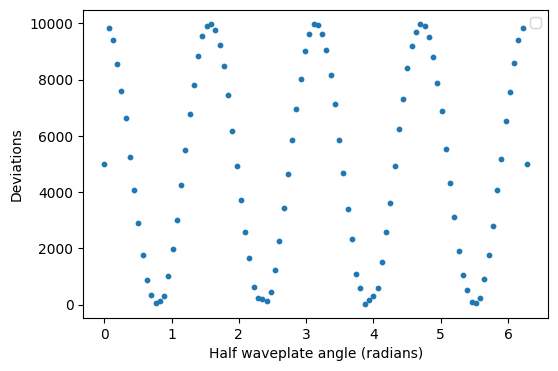

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

x = np.array(angles_to_test)
y = np.array(devs)

def test_func(x, a, b, c):
    return a * np.sin(b * x) + c

# Initial guess for the parameters: [amplitude, frequency, offset]
initial_guess = [3600, 1, 3600]

# Fit the curve
# params, params_covariance = optimize.curve_fit(test_func, x, y, p0=initial_guess)
# print("Fitted parameters:", params)

print(len(x))
print(len(y))

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(x, y, s=10)
#plt.plot(x, test_func(x, *params), label='Fitted function', color='red')

# Adding labels and title
plt.xlabel('Half waveplate angle (radians)')
plt.ylabel('Deviations')
#plt.title('Half waveplate angle deviations from expected photon counts')
plt.legend(loc='best')

plt.show()


This graph displays the deviations from ideal photon count of 2500 photons per detector when the circuit is **balanced**. Minimal deviations occur when the half waveplate is rotated in multiples of π/4 radians.



Now observe the difference when the circuit is imbalanced.

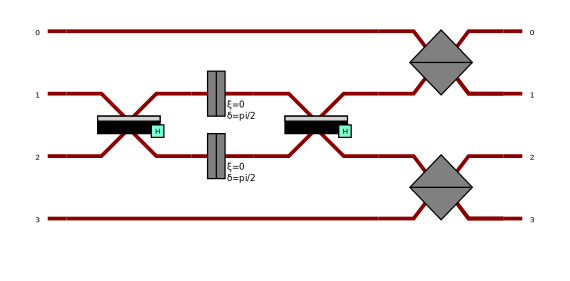

In [87]:
mzi = (pcvl.Circuit(4)
       .add(1, comp.BS().H())

       .add(1, comp.WP(delta=delta1, xsi=xsi1)) # h gate
       .add(2, comp.WP(delta=delta2, xsi=xsi2)) # x gate followed by h gate

       .add(1, comp.BS().H())

       .add(0, comp.PBS())
       .add(2, comp.PBS()))
pcvl.pdisplay(mzi)

In [90]:
devs = []
angles_to_test = np.linspace(0, 2*np.pi, 100)
for angle in angles_to_test:
  delta1.set_value(np.pi/2)
  xsi1.set_value(np.pi/8)

  delta2.set_value(np.pi/2)
  xsi2.set_value(angle)

  processor = pcvl.Processor("SLOS", mzi)
  processor.add_port(0, Port(Encoding.DUAL_RAIL, 'port1'))
  processor.add_port(2, Port(Encoding.DUAL_RAIL, 'port2'))

  input_state = pcvl.BasicState("|0,1,0,0>")
  processor.with_input(input_state)
  sampler = pcvl.algorithm.Sampler(processor)
  sample_count = sampler.sample_count(10000)

  vals = list(sample_count['results'].values())
  deviation = 0
  if len(vals) == 4:
    for i in range(4):
      v = vals[i]
      if i == 0:
        deviation += abs(1275 - v)
      elif i == 1:
        deviation += abs(7250 - v)
      elif i == 2:
        deviation += abs(200 - v)
      else:
        deviation += abs(1275 - v)
    devs.append(deviation)

  if len(vals) == 3:
    for i in range(3):
      v = vals[i]
      if i == 0:
        deviation += abs(1275 - v)
      elif i == 1:
        deviation += abs(7250 - v)
      else:
        deviation += abs(200 - v)
    deviation += abs(1275 - 0)
    devs.append(deviation)

  if len(vals) == 2:
    for i in range(2):
      v = vals[i]
      if i == 0:
        deviation += abs(1275 - v)
      else:
        deviation += abs(7250 - v)
    deviation += abs(200 - 0)
    deviation += abs(1275 - 0)
    devs.append(deviation)



100
100


<ipython-input-91-b06a986d5c1c>:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


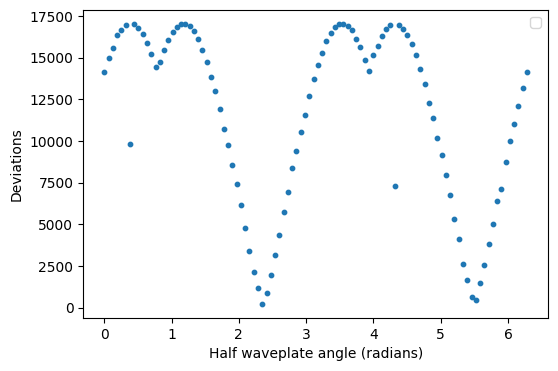

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

x = np.array(angles_to_test)
y = np.array(devs)

def test_func(x, a, b, c):
    return a * np.sin(b * x) + c

# Initial guess for the parameters: [amplitude, frequency, offset]
initial_guess = [3600, 1, 3600]

# Fit the curve
# params, params_covariance = optimize.curve_fit(test_func, x, y, p0=initial_guess)
# print("Fitted parameters:", params)

print(len(x))
print(len(y))

# Create the plot
plt.figure(figsize=(6, 4))
plt.scatter(x, y, s=10)
#plt.plot(x, test_func(x, *params), label='Fitted function', color='red')

# Adding labels and title
plt.xlabel('Half waveplate angle (radians)')
plt.ylabel('Deviations')
#plt.title('Half waveplate angle deviations from expected photon counts')
plt.legend(loc='best')

plt.show()


This graph displays the deviations from ideal count of 1275-7250-200-7250 for an **imbalanced** circuit when the half wave plate is rotated by angles between [0, 2π]. This curve does not exhibit the same sinusoidal behavior as shown previously as a result of not eliminating the unique interference features of the initial beamsplitter.


At this point, we have rigorously confirmed HOM interference in the bias-mitigated model when ξ = 0 + (2k - 1)π/2, k ∈ Z, establishing the indistinguishability of the modes. This serves as a critical component of the standard Bell state measurement procedure, setting us apart from previous research in the field which simply calculates correlations between measurements of the modes' polarization states.
